In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy.stats import t
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
import seaborn as sns

<font size="5">**Question 1**

In [2]:
df = pd.read_csv(r'spy_gfc.csv')
price = df.iloc[:, 5:6]

In [3]:
r = []
for i in range(1, len(price)):
    ret = (price.iloc[i]-price.iloc[i-1])/price.iloc[i-1]
    r.append(ret)
r_std = np.std(r)

In [4]:
mean_p = price['AdjClose'].mean()
std_p = price['AdjClose'].std()

In [5]:
def price_sim(method, df, nsim):
    np.random.seed(1234)
    exp_price = np.zeros((len(df)-1, nsim))
    r = np.zeros((len(df)-1, nsim))
    for i in range(nsim):
        exp_price[0][i] = mean_p
    
    if(method == 'Brownian'): 
        for i in range(nsim):
            r_a = np.random.normal(loc=0.0, scale=r_std, size=(len(df)-1, 1))
            for j in range(len(df)-1):
                r[j][i] = r_a[j]
        for i in range(1,len(df)-1):
            for j in range(nsim):
                exp_price[i][j] = exp_price[i-1][j] + r[i][j]
        exp_mean = exp_price.mean(axis=0)
        exp_std = exp_price.std(axis=0)
        
        mean = exp_mean.mean()
        std = exp_std.mean()
        return mean, std
    
    elif(method == 'Arithmetic'):
        for i in range(nsim):
            r_a = np.random.normal(loc=0.0, scale=r_std, size=(len(df)-1, 1))
            for j in range(len(df)-1):
                r[j][i] = r_a[j]
        for i in range(1,len(df)-1):
            for j in range(nsim):
                exp_price[i][j] = exp_price[i-1][j] * (1 + r[i][j])
        exp_mean = exp_price.mean(axis=0)
        exp_std = exp_price.std(axis=0)
        
        mean = exp_mean.mean()
        std = exp_std.mean()
        return mean, std
    
    elif(method == 'Geometric'):
        for i in range(nsim):
            r_a = np.random.normal(loc=0.0, scale=r_std, size=(len(df)-1, 1))
            for j in range(len(df)-1):
                r[j][i] = r_a[j]
        for i in range(1,len(df)-1):
            for j in range(nsim):
                exp_price[i][j] = exp_price[i-1][j] * math.exp(r[i][j])
        exp_mean = exp_price.mean(axis=0)
        exp_std = exp_price.std(axis=0)
        
        mean = exp_mean.mean()
        std = exp_std.mean()
        return mean, std

    else:
            print("Wrong Method")

In [6]:
mean1,std1 = price_sim('Brownian', price, 25000)
mean2,std2 = price_sim('Arithmetic', price, 25000)
mean3,std3 = price_sim('Geometric', price, 25000)

In [7]:
name = ['Original','Classic_Brownian','Arithmetic','Geometric_Brownian']
mean = [mean_p,mean1,mean2,mean3]
std = [std_p,std1,std2,std3]
result = pd.DataFrame(list(zip(name,mean,std)), columns = ['Name','Mean','Std'])
result

,Name,Mean,Std
0,Original,70.495078,11.174723
1,Classic_Brownian,70.493406,0.161613
2,Arithmetic,70.365064,11.371942
3,Geometric_Brownian,73.667078,12.010054


<font size="5">**Question 2**

In [8]:
def return_calculate(method, price):
    n = len(price)
    r = np.zeros((n-1, 1))
    if(method == 'Brownian'):
        for i in range(n-1):
            ret = price[i+1] - price[i]
            r[i] = ret
        return r
    
    elif(method == 'Arithmetic'):
        for i in range(n-1):
            ret = (price[i+1]/price[i]) - 1.0
            r[i] = ret
        return r
            
    elif(method == 'Geometric'):
        for i in range(n-1):
            ret = np.log(price[i+1]/price[i])
            r[i] = ret
        return r
    
    else:
        print("Wrong Method")

In [9]:
def ewm (x, exp_w, lamda):
    w = []
    sum_w = 0
    n = x.shape[1]
    for i in range(1, len(x.index)+1):
        w.append((1-lamda)*lamda**(i-1))
        sum_w = sum_w + w[i-1]
    for i in range(len(x.index)):   
        exp_w.append(w[i] / sum_w)
    
    
    cov_matrix = np.zeros([n,n])
    for i in range (len(x.index)):
        for j in range (n):
            x.iloc[i,j] = x.iloc[i,j] - np.mean(x.iloc[:,j])
    
            
    for i in range (n):
        for j in range (n):
            temp = exp_w * x.iloc[:,i]
            cov_matrix[i,j] = np.dot(temp, x.iloc[:, j])
            
    return cov_matrix

In [10]:
daily_price = pd.read_csv(r'DailyPrices.csv')
daily_price = daily_price.iloc[: , 1:]
INTC = daily_price["INTC"]
INTC = INTC-INTC.mean()

In [11]:
ret = return_calculate('Arithmetic', INTC)
ret_mean = ret.mean()
ret_std = ret.std()
print(ret_mean)
print(ret_std)

-0.522582198776928
3.4400574204366574


In [12]:
#VaR Normal_dist
returns_dp = daily_price.pct_change()

alpha = 0.05
VaR1 = norm.ppf(alpha, ret_mean, ret_std)

In [13]:
#VaR Normal_dist with EW_Var
daily_price = pd.read_csv('DailyPrices.csv')
daily_price = daily_price.iloc[: , 1:]
returns_dp = daily_price.pct_change()
returns_dp = returns_dp.iloc[1:, :]

exp_w = []
ewm_cov_dp = ewm(returns_dp, exp_w, 0.94)
exp_w = exp_w[::-1]

for i in range(len(returns_dp)):
    returns_dp['INTC'].iloc[i] *= exp_w[i]

ewm_mean = returns_dp['INTC'].mean()
ewm_std = returns_dp['INTC'].std()
        
alpha = 0.05
VaR2 = norm.ppf(alpha, ewm_mean, ewm_std)

In [14]:
#VaR with t_dist
daily_price = pd.read_csv('DailyPrices.csv')
daily_price = daily_price.iloc[: , 1:]

returns_dp = daily_price.pct_change()

dof = len(returns_dp.columns) - 1
VaR3 = np.sqrt((dof-2)/dof) * t.ppf(alpha, dof) * ret_std - ret_mean

[*********************100%***********************]  1 of 1 completed
The VaR value by using historic simulation is -0.039814.
[*********************100%***********************]  1 of 1 completed


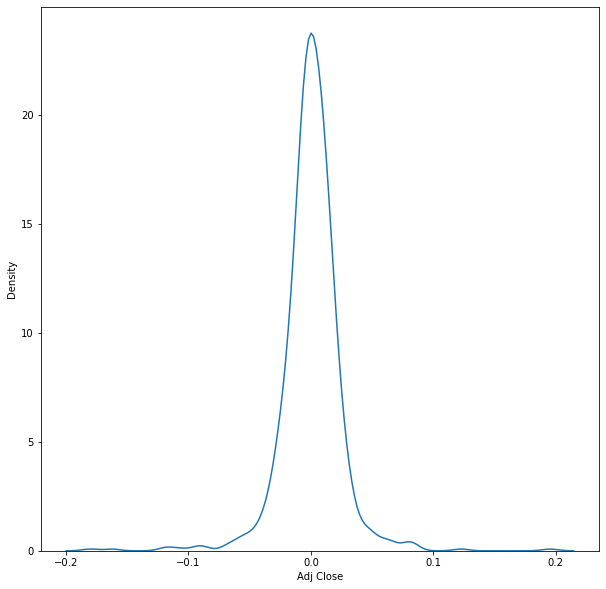

In [15]:
# import data
start = dt.datetime(2019,1,1)
end = dt.datetime.now()
df_yahoo = yf.download("INTC", start, end)['Adj Close']

# Calculate VaR
return4 = return_calculate('Arithmetic', df_yahoo)
std4 = np.sqrt(return4.var())
mean4 = return4.mean()
confidence_level = 0.05 
VaR4 = norm.ppf(confidence_level, mean4, std4)
print('The VaR value by using historic simulation is %f.' % VaR4)

plt.figure(figsize = (10,10))

KDE = yf.download("INTC", start, end)['Adj Close']
temp = KDE.pct_change()
sns.kdeplot(temp)
plt.show()

In [16]:
names_dp = ['Norm_dist', 'Norm_dist with EW_VAR', 'T_dist', 'Historical_sim']
VaRs_dp = [VaR1, VaR2, VaR3, VaR4]

result_dp = pd.DataFrame(list(zip(names_dp,VaRs_dp)), columns = ['Name','VaR'])
result_dp

,Name,VaR
0,Norm_dist,-6.180973
1,Norm_dist with EW_VAR,-0.000521
2,T_dist,-5.131318
3,Historical_sim,-0.039814


<font size="5">**Question 3**

<font size="5">I will use normal distribution to calculate VaR

In [17]:
port1 = pd.read_csv(r'portfolio_A.csv')
port2 = pd.read_csv(r'portfolio_B.csv')
port3 = pd.read_csv(r'portfolio_C.csv')

port = pd.read_csv(r'portfolio.csv')

In [18]:
#Portfolio A
stock1 = port1['Stock']
holding1 = port1['Holding']
price1 = daily_price[stock1]
weight1 = np.zeros((len(stock1),1))
tot1 = 0
for i in range(len(stock1)):
    tot1 += holding1[i] * daily_price[stock1[i]].iloc[0]
for i in range(len(stock1)):
    w = (holding1[i] * daily_price[stock1[i]].iloc[0]) / tot1
    weight1[i] = w
    
    
returns1 = price1.pct_change()
cov1 = returns1.cov()
port_std1 = np.sqrt(weight1.T @ cov1 @ weight1)


x = np.arange(-0.5,0.5,0.001)
norm_dist1 = norm.pdf(x, 0, port_std1[0][0])
alpha = 0.05
VaR1 = norm.ppf(alpha, 0, port_std1[0][0])

In [19]:
#Portfolio B
stock2 = port2['Stock']
holding2 = port2['Holding']
price2 = daily_price[stock2]
weight2 = np.zeros((len(stock2),1))
tot2 = 0
for i in range(len(stock2)):
    tot2 += holding2[i] * price2[stock2[i]].iloc[0]
for i in range(len(stock2)):
    w = (holding2[i] * price2[stock2[i]].iloc[0]) / tot2
    weight2[i] = w
    
returns2 = price2.pct_change()
cov2 = returns2.cov()
port_std2 = np.sqrt(weight2.T @ cov2 @ weight2)


norm_dist2 = norm.pdf(x, 0, port_std2[0][0])
VaR2 = norm.ppf(alpha, 0, port_std2[0][0])

In [20]:
#Portfolio C
stock3 = port3['Stock']
holding3 = port3['Holding']
price3 = daily_price[stock3]
weight3 = np.zeros((len(stock3),1))
tot3 = 0
for i in range(len(stock3)):
    tot3 += holding3[i] * price3[stock3[i]].iloc[0]
for i in range(len(stock3)):
    w = (holding3[i] * price3[stock3[i]].iloc[0]) / tot3
    weight3[i] = w
    
returns3 = price3.pct_change()
cov3 = returns3.cov()
port_std3 = np.sqrt(weight3.T @ cov3 @ weight3)


norm_dist3 = norm.pdf(x, 0, port_std3[0][0])
VaR3 = norm.ppf(alpha, 0, port_std3[0][0])

In [21]:
#Whole Portfolio 
stock = port['Stock']
holding = port['Holding']
price = daily_price[stock]
weight = np.zeros((len(stock),1))
tot = 0
for i in range(len(stock)):
    tot += holding[i] * price[stock[i]].iloc[0]
for i in range(len(stock)):
    w = (holding[i] * price[stock[i]].iloc[0]) / tot
    weight[i] = w
    
returns = price.pct_change()
cov = returns.cov()
port_std = np.sqrt(weight.T @ cov @ weight)


norm_dist = norm.pdf(x, 0, port_std[0][0])
VaR = norm.ppf(alpha, 0, port_std[0][0])

In [22]:
names = ['Port_A', 'Port_B', 'Port_C', 'Tot_Port']
VaRs = [VaR1, VaR2, VaR3, VaR]

results = pd.DataFrame(list(zip(names,VaRs)), columns = ['Name','VaR'])
results

,Name,VaR
0,Port_A,-0.016521
1,Port_B,-0.015009
2,Port_C,-0.011269
3,Tot_Port,-0.013936
